This cell installs the required Python libraries for our project:
- **transformers**: Provides state-of-the-art Transformer models and tools.
- **datasets**: Offers ready-to-use datasets and utility functions.
- **peft**: Parameter-Efficient Fine-Tuning library, which includes LoRA and DoRA methods.
- **accelerate**: Utility library for distributed training and hardware acceleration.
- **optuna**: Hyperparameter optimization framework.

It is important to note that after installing these packages in a Jupyter environment, you typically need to restart the session or kernel for the new installations to take effect.


In [ ]:
# Install dependencies (after running this cell restart the Session/Kernel)
!pip install transformers datasets peft accelerate optuna -U -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.1/411.1 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

This cell imports the primary libraries and modules used in the notebook:

- **torch**, **numpy**, **matplotlib**, **seaborn**: Core scientific and visualization libraries.
- **Path** from `pathlib`: Helps manage file paths in a more flexible way.
- **transformers** modules such as `AutoTokenizer`, `AutoModelForSequenceClassification`, `Trainer`, and more, which provide building blocks for NLP tasks.
- **datasets**: Used to load our dataset.
- **peft**: Contains methods to apply LoRA/DoRA configurations.
- **sklearn.metrics**: Used to compute performance metrics like classification reports and confusion matrices.


In [ ]:
# Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    DataCollatorWithPadding
)
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, PeftModel
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_fscore_support
)

Sets up main configuration parameters:
- **MODEL_ID**: The Hugging Face model checkpoint name to be used.
- **DATASET_NAME**: Dataset identifier (in this case, a "sms_spam" dataset).
- **ADAPTER_PATH**: Local path to save the fine-tuned adapter model.
- **DEVICE**: Chooses GPU if available; otherwise defaults to CPU.

This ensures all subsequent code references the correct model/dataset and computes on the right hardware.


In [ ]:
# Configuration
MODEL_ID = "answerdotai/ModernBERT-base"        # the model to be imported from HF hub
DATASET_NAME = "sms_spam"                       # the dataset to be used for sequence classification - sms spam vs. not-spam
ADAPTER_PATH = "./modernbert-sms-dora-best"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DEVICE = torch.device("cuda")

# DEVICE = torch.device("cpu")

Disables `torch.compile` (part of PyTorch 2.x features) to avoid certain performance or stability issues that might arise with some Hugging Face transformers or custom modules. This can help ensure more reliable training.


In [ ]:
# Disable torch.compile for stability
torch._dynamo.config.disable = True

1. **Load the dataset**: Retrieves the dataset from Hugging Face Datasets by name ("sms_spam").
2. **Split the dataset**: Uses `train_test_split` to split the 'train' portion into training and test sets (80/20 split). A fixed `seed=42` ensures reproducibility.


In [ ]:
# 1. Load and prepare dataset
dataset = load_dataset(DATASET_NAME)
split_dataset = dataset['train'].train_test_split(test_size=0.2, seed=42)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/359k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5574 [00:00<?, ? examples/s]

In [ ]:
split_dataset["test"]

Dataset({
    features: ['sms', 'label'],
    num_rows: 1115
})

1. **Tokenizer**: Automatically downloads and loads the tokenizer for the specified model `MODEL_ID`.
2. **Base Model**: Loads a pretrained sequence classification model with 2 labels: "ham" (0) and "spam" (1).
3. **Device**: The model is immediately moved to the GPU (or CPU if GPU is not available), ensuring faster computations if GPU is present.


In [ ]:
# 2. Initialize model components
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)                 # loading the tokenizer for ModernBERT
base_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_ID,
    num_labels=2,       # defining the number of neurons in the classification head being attached at the end of the ModernBERT-base model
                        # the number of distinct classes we have in our seq classification problem
    id2label={0: "ham", 1: "spam"}
).to(DEVICE)                                                        # loading the ModernBERT model, and then moving it to the available device GPU/CPU

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1. **Tokenization**:
   - Defines a `tokenize_function` that truncates each text to a maximum length of 128 tokens.
   - Applies the tokenizer to the dataset splits, removing the original "sms" column and renaming "label" to "labels" (required for Trainer).

2. **evaluate_model function**:
   - Creates a temporary Trainer for evaluation with basic settings (no logging to external sources).
   - Predicts on the specified dataset split using the provided model.
   - Computes classification metrics (precision, recall, f1-score) via `classification_report`.
   - Plots a confusion matrix for a quick visualization of misclassifications.

3. **Initial Evaluation**:
   - Invokes `evaluate_model` on the base (unfinetuned) model using the test split to see baseline performance.


Map:   0%|          | 0/4459 [00:00<?, ? examples/s]

Map:   0%|          | 0/1115 [00:00<?, ? examples/s]


Evaluating Base Model Set


              precision    recall  f1-score   support

         ham       0.86      0.87      0.86       966
        spam       0.05      0.05      0.05       149

    accuracy                           0.76      1115
   macro avg       0.45      0.46      0.46      1115
weighted avg       0.75      0.76      0.75      1115



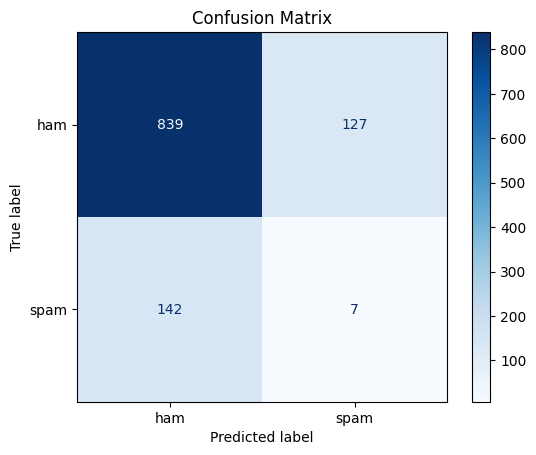

In [ ]:
# 3.1 Tokenize the dataset before evaluation
def tokenize_function(examples):
    # Remove return_tensors='pt' so HF Datasets keeps outputs as lists
    # (which the DataCollatorWithPadding will batch into tensors)
    return tokenizer(
        examples["sms"],
        truncation=True,
        max_length=128
    )

tokenized_dataset = split_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["sms"]
).rename_column("label", "labels")

# 3.2 Evaluate base model before fine-tuning
def evaluate_model(model, dataset_split, split_name="Test"):
    print(f"\n{'='*40}")
    print(f"Evaluating {split_name} Set")
    print(f"{'='*40}")

    # Define evaluation arguments
    eval_args = TrainingArguments(
        output_dir="./pre_fine_tuning_results",
        report_to="none"  # Disable all logging integrations, including wandb
    )

    trainer = Trainer(
        args=eval_args,
        model=model,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
        processing_class=tokenizer
    )

    outputs = trainer.predict(dataset_split)
    predictions = np.argmax(outputs.predictions, axis=1)
    labels = outputs.label_ids

    print(classification_report(labels, predictions, target_names=["ham", "spam"]))
    plot_confusion_matrix(labels, predictions)

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["ham", "spam"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# Pre-training evaluation on the tokenized dataset
evaluate_model(base_model, tokenized_dataset["test"], "Base Model")

Defines a DoRA (Weight-decomposed Low-Rank Adaptation) config:
- `r=8` and `lora_alpha=32`: Controls the rank of DoRA matrices and their scaling factor.
- `target_modules`: Specifies which parts of the model (layers) to apply DoRA to.
- `lora_dropout=0.2`: Dropout for DoRA modules to help regularize.
- `bias="none"`: Indicates how biases are handled in DoRA.
- `modules_to_save`: Certain modules that must remain trainable or saved in full precision.
- `use_dora=True`: Enables the DoRA technique.
- `init_lora_weights="gaussian"`: Initializes DoRA parameters with a Gaussian distribution.


In [ ]:
base_model

ModernBertForSequenceClassification(
  (model): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(50368, 768, padding_idx=50283)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
          (rotary_emb): ModernBertRotaryEmbedding()
          (Wo): Linear(in_features=768, out_features=768, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=768, out_features=2304, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=1152, out_features=768, bias=False)
        )
      

In [ ]:
# 4. Optimized DoRA configuration
dora_config = LoraConfig(
    r=8,        # the rank of decomposed matrices
    lora_alpha=32,
    target_modules=["Wqkv", "Wi", "Wo", "dense"],
    lora_dropout=0.2,
    bias="none",
    task_type="SEQ_CLS",
    modules_to_save=["classifier"],
    use_dora=True,
    init_lora_weights="gaussian",
    inference_mode=False
)

Wraps the base model with the LoRA/DoRA configuration using `get_peft_model`.
- **model.print_trainable_parameters()** prints how many parameters are trainable under the current configuration, confirming that only the lightweight LoRA/DoRA layers (plus any specified modules) will be updated during fine-tuning.


In [ ]:
# 5. Apply DoRA adapters
model = get_peft_model(base_model, dora_config)
model.print_trainable_parameters()

trainable params: 1,839,362 || all params: 151,445,764 || trainable%: 1.2145


Specifies various hyperparameters and settings for the Hugging Face Trainer:
- `output_dir`: Directory to store model checkpoints and logs.
- `learning_rate=5e-5`: Base learning rate for fine-tuning.
- `num_train_epochs=8`: How many epochs to train for.
- `eval_strategy="steps"` + `eval_steps=50`: Evaluate every 50 training steps.
- `save_strategy="steps"` + `save_steps=50`: Save model checkpoints every 50 steps.
- `load_best_model_at_end=True`: Restores the best checkpoint (based on `eval_loss`) after training finishes.
- Other parameters like `fp16`, `warmup_ratio`, `optim`, and `lr_scheduler_type` further tune performance and stability.


In [ ]:
# 6. Training arguments
training_args = TrainingArguments(
    output_dir=ADAPTER_PATH,
    learning_rate=5e-5,         # 5*0.00005
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=8,
    weight_decay=0.1,       # L2-regularization
    logging_steps=20,       # 20*32
    eval_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    fp16=torch.cuda.is_available(),         # fp16 being used for the fine-tuning phase
    optim="adamw_torch",
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    report_to="none",
    push_to_hub=False,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    gradient_accumulation_steps=1,
    group_by_length=True,
    dataloader_num_workers=2,
    torch_compile=False
)

Defines a custom metric function for the Trainer:
- Uses `precision_recall_fscore_support` to compute macro-averaged precision, recall, and F1 scores.
- Calculates overall accuracy.
- Returns a dictionary of these values, which the Trainer will log and use for model comparison.


In [ ]:
# 7. Metrics calculation
def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=1)
    labels = p.label_ids

    # Compute MACRO metrics only (or MICRO if you prefer),
    # and keep overall accuracy. This greatly simplifies your logs.
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average="macro", zero_division=0
    )
    accuracy = (predictions == labels).mean()

    return {
        "accuracy": accuracy,
        "macro_precision": precision,
        "macro_recall": recall,
        "macro_f1": f1
    }

Creates an instance of `EarlyStoppingCallback` to stop training early if:
- The validation loss does not improve beyond a certain threshold (`early_stopping_threshold=0.001`) for `early_stopping_patience=3` evaluation rounds.
This helps avoid overfitting and saves computational time.


In [ ]:
# 8. Early stopping
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3,
    early_stopping_threshold=0.001
)

Instantiates the `Trainer` with:
- The model augmented with DoRA.
- Training arguments and dataset splits.
- Custom metrics function and early stopping callback.
- A data collator (`DataCollatorWithPadding`) that handles dynamic padding for each batch.
- The tokenizer is passed as `processing_class`.


In [ ]:
# 9. Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping],
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    processing_class=tokenizer
)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Starts the training process with `trainer.train()`, which will:
- Iterate over the training set.
- Periodically evaluate on the test set (as set in `training_args`).
- Perform early stopping if necessary.
- Keep track of training and evaluation logs (loss, evaluation metrics, etc.).


In [ ]:
# 10. Run training
train_results = trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
50,0.561900,0.281948,0.866368,0.433184,0.500000,0.464200
100,0.041300,0.097524,0.967713,0.974419,0.884871,0.923166
150,0.068600,0.051553,0.985650,0.969014,0.969014,0.969014
200,0.085300,0.044139,0.986547,0.983132,0.958179,0.970184
250,0.059000,0.042317,0.989238,0.990768,0.962570,0.976077
300,0.032600,0.036144,0.992825,0.990011,0.978831,0.984328
350,0.019000,0.062273,0.982063,0.948214,0.978296,0.962534
400,0.040800,0.053794,0.989238,0.990768,0.962570,0.976077
450,0.023600,0.044497,0.991031,0.980633,0.980633,0.980633


1. **trainer.save_model**: Saves the best model checkpoint to `final_model_path`.
2. **tokenizer.save_pretrained**: Saves the tokenizer files to the same folder.
3. **PeftModel.from_pretrained**: Loads the LoRA/DoRA adapter weights onto the original base model.
4. **model.merge_and_unload()**: Merges adapter weights with the base model and unloads adapter layers, resulting in a standalone model with updated weights.


In [ ]:
# 11. Save and load best model
final_model_path = "./modernbert-sms-dora-final"
trainer.save_model(final_model_path)
tokenizer.save_pretrained(final_model_path)

model = PeftModel.from_pretrained(base_model, final_model_path)
model = model.merge_and_unload().to(DEVICE)

/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Re-evaluates the final, fine-tuned model on the test set:
- Prints performance metrics and plots a confusion matrix using the same `evaluate_model` function.
- Helps confirm improvements compared to the baseline.



Evaluating Fine-tuned Model on Test Set

Evaluating Fine-tuned Model Set


              precision    recall  f1-score   support

         ham       0.99      1.00      1.00       966
        spam       0.99      0.96      0.97       149

    accuracy                           0.99      1115
   macro avg       0.99      0.98      0.98      1115
weighted avg       0.99      0.99      0.99      1115



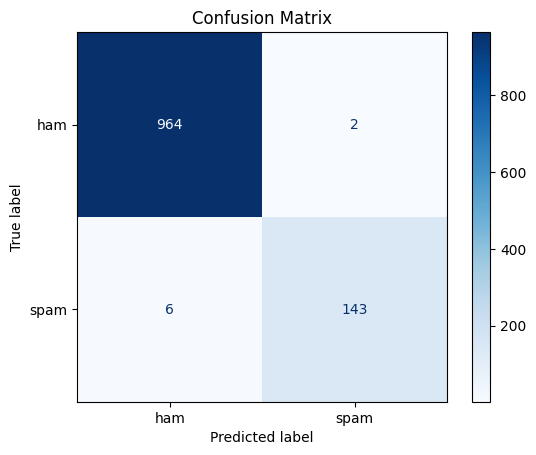

In [ ]:
# 12. Post-training evaluation
print("\nEvaluating Fine-tuned Model on Test Set")
evaluate_model(model, tokenized_dataset["test"], "Fine-tuned Model")

Plots key insights into model training progress:
1. **Loss Dynamics**: Compares training vs. validation loss over steps.
2. **Gradient Norm Progression**: Shows how gradient norms changed during training (useful for diagnosing exploding/vanishing gradients).
3. **Prediction Distribution**: Uses a stacked histogram (with seaborn) to visualize how the model’s correct and incorrect predictions were distributed between the "ham" and "spam" classes in the test set.


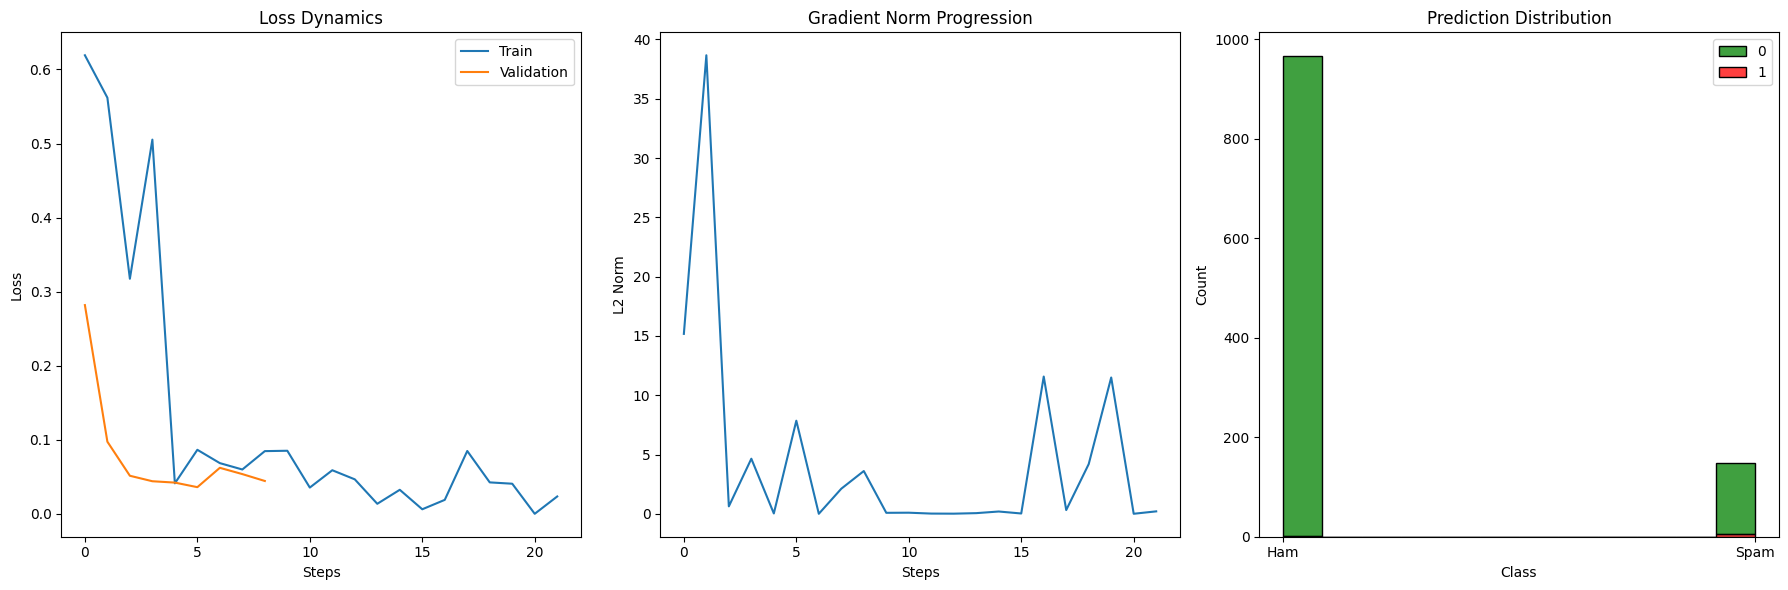

In [ ]:
# 13. Training dynamics visualization
def plot_training_insights(log_history):
    train_loss = [x['loss'] for x in log_history if 'loss' in x]
    eval_loss = [x['eval_loss'] for x in log_history if 'eval_loss' in x]
    grad_norms = [x.get('grad_norm', 0) for x in log_history if 'grad_norm' in x]

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.plot(train_loss, label='Train')
    plt.plot(eval_loss, label='Validation')
    plt.title('Loss Dynamics')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(grad_norms)
    plt.title('Gradient Norm Progression')
    plt.xlabel('Steps')
    plt.ylabel('L2 Norm')

    plt.subplot(1, 3, 3)
    test_output = trainer.predict(tokenized_dataset["test"])
    test_preds = np.argmax(test_output.predictions, axis=1)
    test_labels = test_output.label_ids
    correct = (test_preds == test_labels)
    sns.histplot([test_labels[correct], test_labels[~correct]],
                multiple="stack", palette=["green", "red"])
    plt.title('Prediction Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['Ham', 'Spam'])

    plt.tight_layout()
    plt.show()

plot_training_insights(trainer.state.log_history)

Performs a quick inspection of misclassified samples:
- Identifies misclassified indices by comparing predicted labels vs. true labels.
- Prints the first few examples of misclassifications, showing:
  - The original text (truncated if too long).
  - The true label vs. the predicted label.
- If no misclassifications, prints a message indicating perfect classification.


In [ ]:
# 14. Error analysis
test_output = trainer.predict(tokenized_dataset["test"])
test_preds = np.argmax(test_output.predictions, axis=1)
test_labels = test_output.label_ids

misclassified = np.where(test_preds != test_labels)[0]
if len(misclassified) > 0:
    print("\nError Analysis:")
    for idx in misclassified[:3]:
        # Cast `idx` to a Python int
        original_text = split_dataset["test"][int(idx)]["sms"]
        print(f"\nError Case {idx+1}:")
        print(f"Text: {original_text[:200]}{'...' if len(original_text)>200 else ''}")
        print(f"True: {model.config.id2label[test_labels[idx]]}")
        print(f"Predicted: {model.config.id2label[test_preds[idx]]}")
else:
    print("\nPerfect classification on test set!")


Error Analysis:

Error Case 13:
Text: "GRAN ONLYFOUND OUT AFEW DAYS AGO.CUSOON HONI"

True: ham
Predicted: spam

Error Case 70:
Text: "Hi darlin i cantdo anythingtomorrow as myparents aretaking me outfor a meal. when are u free? Katexxx"

True: spam
Predicted: ham

Error Case 117:
Text: I thk 50 shd be ok he said plus minus 10.. Did ü leave a line in between paragraphs?

True: spam
Predicted: ham
